### Homework 8

Build a model with a lower average cross-validated RMSE than the best model that we saw in class (-0.008575141851714435) for prediction hourly returns for SOL

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [2]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV




##### Load data

In [3]:

connection_string = 'sqlite:///data/data.db'


ohlc = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc
''', connection_string)

ohlc.shape

(11627, 9)

In [4]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [5]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [6]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [7]:
ohlc

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC
...,...,...,...,...,...,...,...,...,...
11622,2021-12-14 20:00:00,178.99,181.27,178.72,180.28,628.699000,1.130815e+05,COMP,ETH
11623,2021-12-14 21:00:00,180.15,183.76,179.96,183.43,2453.455000,4.447119e+05,COMP,ETH
11624,2021-12-14 22:00:00,183.31,186.74,182.60,185.24,2086.017000,3.865710e+05,COMP,ETH
11625,2021-12-14 23:00:00,185.22,186.09,183.88,185.08,416.028000,7.698720e+04,COMP,ETH


In [8]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


#### Data Formatting

In [9]:
tokens = ohlc.token.unique()
tokens

array(['BTC', 'ETH', 'USDT', 'SOL', 'ADA', 'DOT', 'AVAX', 'ATOM', 'CRV',
       'AAVE', 'COMP'], dtype=object)

In [10]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X0 = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [11]:
X0.shape

(1057, 22)

In [12]:
X0.tail()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.004810,0.158369,0.005961,0.002463,0.0001,0.216740,0.002798,0.225286,0.014437,...,0.239258,0.008227,0.254118,-0.000471,0.255464,0.003049,0.207758,0.009387,0.284268,0.006813
2021-12-14 21:00:00,0.142237,0.019797,0.170096,0.016737,0.002652,0.0000,0.218492,0.025892,0.224116,0.012141,...,0.241603,0.019207,0.254350,0.019303,0.263456,0.021277,0.222014,0.022490,0.281497,0.017473
2021-12-14 22:00:00,0.151148,0.010414,0.172081,0.004623,0.002684,0.0000,0.246122,0.015624,0.232362,0.009295,...,0.268875,0.026851,0.253472,0.012933,0.270895,0.023810,0.220598,0.006242,0.275083,0.009868
2021-12-14 23:00:00,0.149424,-0.000302,0.170257,-0.003195,0.002823,0.0001,0.238235,-0.010027,0.231115,-0.000157,...,0.301778,0.032506,0.245708,-0.009576,0.268758,-0.011628,0.219474,-0.003013,0.271229,-0.000864
2021-12-15 00:00:00,0.143079,-0.001448,0.159883,-0.000641,0.002816,0.0000,0.228867,0.002517,0.220068,-0.007715,...,0.296444,0.005576,0.234522,-0.003223,0.242546,-0.002941,0.213360,0.001659,0.246067,-0.001027


In [13]:
### Adding features here

return_period = 24

X1_lag = pd.concat([(X0.loc[:, ( 'ret_SOL')]).diff(i) for i in [return_period, return_period*2]], axis=1).dropna()
X1_lag.columns = ['ret_SOL_24L', 'ret_SOL_48L']

X2_btc_sol = pd.DataFrame(X0['vol_SOL'] - X0['vol_BTC'])
X2_btc_sol.columns = ['voldiff_btc_sol']




In [14]:
X2_btc_sol

,voldiff_btc_sol
ts,
2021-11-01 00:00:00,0.000000
2021-11-01 01:00:00,0.000000
2021-11-01 02:00:00,0.000000
2021-11-01 03:00:00,0.000000
2021-11-01 04:00:00,0.000000
...,...
2021-12-14 20:00:00,0.080382
2021-12-14 21:00:00,0.076255
2021-12-14 22:00:00,0.094975


In [15]:


X = pd.concat([X0, X1_lag, X2_btc_sol], axis=1)
X.tail(10)

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP,ret_SOL_24L,ret_SOL_48L,voldiff_btc_sol
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 15:00:00,0.117469,0.002637,0.151109,0.006183,0.001946,0.0000,0.211063,0.013985,0.201320,0.002993,...,0.003253,0.264338,0.002985,0.170596,0.003712,0.234892,0.012890,0.025301,0.016611,0.093594
2021-12-14 16:00:00,0.129451,-0.009530,0.156342,-0.008598,0.002085,0.0001,0.225675,-0.015851,0.210767,-0.007177,...,-0.006021,0.259651,-0.011905,0.183133,-0.008851,0.254072,-0.016880,0.010426,-0.013511,0.096224
2021-12-14 17:00:00,0.129951,-0.002775,0.148891,-0.005720,0.002206,0.0000,0.227205,-0.014204,0.213469,0.000569,...,0.001398,0.246083,0.003012,0.187853,0.003976,0.251901,0.000054,-0.004345,-0.021593,0.097253
2021-12-14 18:00:00,0.133732,-0.001909,0.153274,-0.001161,0.002194,0.0000,0.219407,-0.009906,0.217066,-0.005114,...,-0.004188,0.250553,-0.009009,0.193156,-0.001218,0.268962,-0.019010,-0.016800,-0.031387,0.085675
2021-12-14 19:00:00,0.136406,0.000402,0.159860,-0.002922,0.002354,0.0000,0.220576,-0.001624,0.223436,0.000326,...,-0.007009,0.256996,-0.006061,0.206319,-0.005855,0.286230,-0.011428,0.002750,-0.001339,0.084169
2021-12-14 20:00:00,0.136358,0.004810,0.158369,0.005961,0.002463,0.0001,0.216740,0.002798,0.225286,0.014437,...,-0.000471,0.255464,0.003049,0.207758,0.009387,0.284268,0.006813,0.025783,0.007644,0.080382
2021-12-14 21:00:00,0.142237,0.019797,0.170096,0.016737,0.002652,0.0000,0.218492,0.025892,0.224116,0.012141,...,0.019303,0.263456,0.021277,0.222014,0.022490,0.281497,0.017473,0.035472,0.026064,0.076255
2021-12-14 22:00:00,0.151148,0.010414,0.172081,0.004623,0.002684,0.0000,0.246122,0.015624,0.232362,0.009295,...,0.012933,0.270895,0.023810,0.220598,0.006242,0.275083,0.009868,0.006610,0.021754,0.094975
2021-12-14 23:00:00,0.149424,-0.000302,0.170257,-0.003195,0.002823,0.0001,0.238235,-0.010027,0.231115,-0.000157,...,-0.009576,0.268758,-0.011628,0.219474,-0.003013,0.271229,-0.000864,-0.036372,-0.014351,0.088811


Shifting y variable by 1 so that the y variable is future data

In [16]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [17]:
X.head()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP,ret_SOL_24L,ret_SOL_48L,voldiff_btc_sol
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
2021-11-01 01:00:00,0.0,0.004357,0.0,0.006874,0.0,0.0000,0.0,0.027359,0.0,0.003203,...,0.008193,0.0,0.000725,0.0,0.008043,0.0,-0.002281,NaN,NaN,0.0
2021-11-01 02:00:00,0.0,-0.004508,0.0,-0.005322,0.0,-0.0002,0.0,-0.009879,0.0,-0.008667,...,-0.025419,0.0,-0.031791,0.0,-0.009171,0.0,-0.006020,NaN,NaN,0.0
2021-11-01 03:00:00,0.0,-0.012132,0.0,-0.013126,0.0,0.0001,0.0,-0.021692,0.0,-0.007618,...,-0.013943,0.0,-0.010431,0.0,-0.013301,0.0,-0.022273,NaN,NaN,0.0
2021-11-01 04:00:00,0.0,-0.010186,0.0,-0.010679,0.0,0.0000,0.0,-0.003039,0.0,-0.006903,...,-0.020046,0.0,0.004514,0.0,-0.016452,0.0,-0.024002,NaN,NaN,0.0


In [18]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

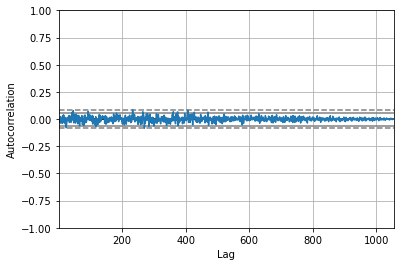

In [19]:
autocorrelation_plot(y[1:])

In [20]:
pd.isnull(X).sum()

vol_BTC             0
ret_BTC             1
vol_ETH             0
ret_ETH             1
vol_USDT            0
ret_USDT            1
vol_SOL             0
ret_SOL             1
vol_ADA             0
ret_ADA             1
vol_DOT             0
ret_DOT             1
vol_AVAX            0
ret_AVAX            1
vol_ATOM            0
ret_ATOM            1
vol_CRV             0
ret_CRV             1
vol_AAVE            0
ret_AAVE            1
vol_COMP            0
ret_COMP            1
ret_SOL_24L        49
ret_SOL_48L        49
voldiff_btc_sol     0
dtype: int64

In [21]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573322,
 'ret_BTC': -0.01384862380414729,
 'vol_ETH': 0.023571512894692854,
 'ret_ETH': 0.030649212659338242,
 'vol_USDT': 0.0068501801913109055,
 'ret_USDT': -0.04440085499052747,
 'vol_SOL': 0.03485259726638475,
 'ret_SOL': -0.029855064193406503,
 'vol_ADA': 0.03888023343700738,
 'ret_ADA': 0.00024928333961420914,
 'vol_DOT': 0.05904076845167186,
 'ret_DOT': 0.008193946995455023,
 'vol_AVAX': 0.041408511560781514,
 'ret_AVAX': 0.01691945028976705,
 'vol_ATOM': -0.0022346077856851467,
 'ret_ATOM': 0.05546161881659773,
 'vol_CRV': 0.019828890149893356,
 'ret_CRV': -0.005844145396121428,
 'vol_AAVE': 0.0360507780728068,
 'ret_AAVE': 0.019895686732066185,
 'vol_COMP': 0.059842585308615054,
 'ret_COMP': 0.020113141490153072,
 'ret_SOL_24L': 0.007647023968904348,
 'ret_SOL_48L': -0.052225486579257255,
 'voldiff_btc_sol': 0.017889199156745673}

#### Setting up transformers

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [23]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [24]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train, y_train)
#         score = mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

In [25]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.01382478738592176

In [26]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.012803935360755605

In [27]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.01363733487087019

In [28]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.011607067332651076

In [29]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.008582673839055125

In [30]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.009011389888046317

In [31]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 15, 20, 22],
    'model__alpha': [0.05, 0.1, 0.5,  1, 1.5, 2]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.05, 0.1, 0.5, 1, 1.5, 2],
                         'pca__n_components': [1, 5, 10, 15, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [32]:
search.best_params_

{'model__alpha': 0.05, 'pca__n_components': 22}

In [33]:
best_model = search.best_estimator_

In [34]:
evaluate_model(best_model, X, y)

-0.008536329090548774

#### This model performed better than the best model in the class

#### Checking learning curve of the model

<module 'matplotlib.pyplot' from 'C:\\Users\\SANDEEP SINGH\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

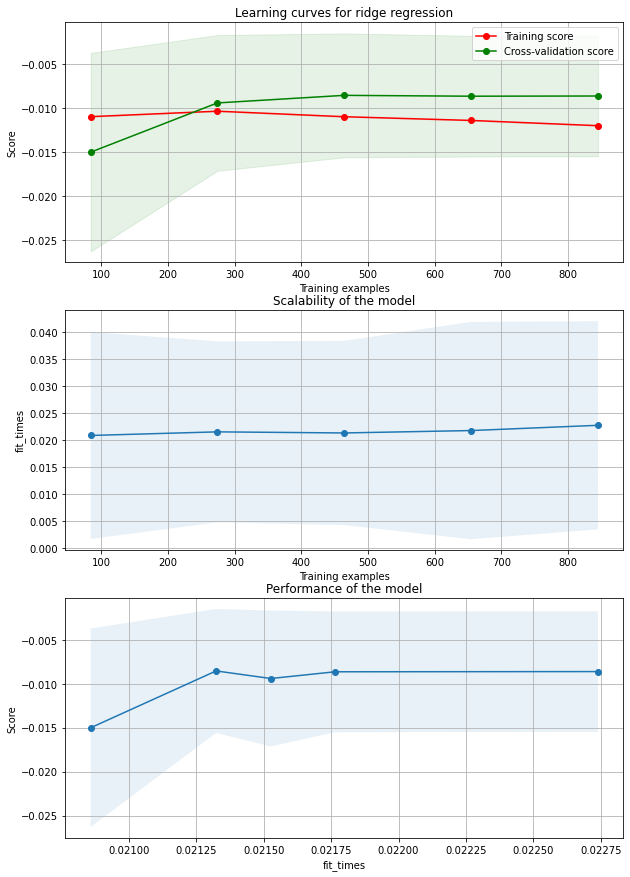

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


In [36]:
#pickle.dump(best_model, open('best_model.pkl', 'wb'))